Imports

In [1]:
#setting system path
import os, sys
# Get the path to the project root (one level up from /jupyter)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add it to the system path if it's not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)

#Python libraries
from langgraph.graph import StateGraph
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import START, END
from langgraph.checkpoint.memory import InMemorySaver


#Import Project Libraries
from src.llm_chain.chains import (_ambiguity_checker_chain,
                                  _clarifiaction_ques_generation_chain,
                                  _query_consolidator_chain,
                                  _llm_with_context_chain,
                                  _retrieval_required_checker_chain,
                                   _llm_without_context_chain )
from src.schema.state_schema import StateSchema
from src.llm_chain.llm_builder import get_llm_model
from src.retrieval.content_retriever import content_retriever



In [6]:


# -------- NODE 2 ------------
def node_ambiguity_check(state:StateSchema):

    response = _ambiguity_checker_chain(state['conversation_history'],)

    return {
        "clarification_need": response["clarification_need"],
        "ambiguity_reason": response["ambiguity_reason"],
        "ambiguity_score": response["ambiguity_score"],
        "stop_reason": response["stop_reason"]
    }

# -------- NODE 3 ------------
def node_clarification_ques_gen(state: StateSchema):

    response = _clarifiaction_ques_generation_chain(state['conversation_history'],
                                         state['ambiguity_reason'],
                                         state['clarifications_asked_count'])
    
    print("Legal AI : ", response)
 
    return {'conversation_history':[AIMessage(content=response)],
            'clarifications_asked_count': state['clarifications_asked_count'] + 1}

# -------- NODE 4 ------------
def node_simple_llm_call(state: StateSchema):
    response = _llm_without_context_chain

    print("Legal AI : ", response)

    return{
        "conversation_history": AIMessage(content=response)
    }

# -------- Node 5 ------------
def node_retrieve_data(state: StateSchema):
    return content_retriever

# -------- NODE 6 ------------
def node_generate_llm_response_with_retrieved_context(state: StateSchema, contexts):

    response= _llm_with_context_chain(state["conversation_history"], contexts)

    print("Legal AI : ", response)

    return {
        'conversation_history':AIMessage(content=response)
        }

# -------- NODE 7 ------------
def node_consolidator(state: StateSchema):

    response = _query_consolidator_chain(state['original_user_query'], state['conversation_history'])

    return {
        "consolidated_query": response
    }

# -------- NODE 8 ------------
def node_retrieval_decider(state: StateSchema):
    response = _retrieval_required_checker_chain(state["conversation_history"])

    return {
        "retrieval_needed": response
    }


# ---------- FUNCTION ------------
def check_stop_condition(state: StateSchema):

    if state['clarifications_asked_count'] >=3:
        {'clarification_need': "No",
         'stop_reason': "max_count_reached"}
    
    if state['clarification_need'] == "No":
        return True
    
    else: return False

# ---------- FUNCTION ------------
def retrieval_router(state: StateSchema):

    if state['retrieval_needed'] == "RETRIEVE":
        True
    else: False
    

# -------- FUNCTION ------------
def create_initial_state(state: StateSchema, user_input):

    user_input = input("").strip()
    print("You : ", user_input)
    
    return {
        "conversation_history": [HumanMessage(content=user_input)],
        'original_user_query': user_input
    }

In [3]:


#declare agent state graph to use for building node and edges
graph = StateGraph(StateSchema)
checkpointer = InMemorySaver()

#Add nodes in graph
#graph.add_node("user_input_node", node_take_user_input)
graph.add_node("ambiguity_checker", node_ambiguity_check)
graph.add_node("clarification_ques_gen", node_clarification_ques_gen)
graph.add_node("retrieve_data", node_retrieve_data)
graph.add_node("generate_with_retrieved_data", node_generate_llm_response_with_retrieved_context)
graph.add_node("simple_llm_call", node_simple_llm_call)
graph.add_node("consolidator", node_consolidator)
graph.add_node("retrieval_decider", node_retrieval_decider)

#Add Edges
#graph.add_edge(START, "user_input_node")
graph.add_edge(START, "ambiguity_checker")
graph.add_conditional_edges("ambiguity_checker", check_stop_condition, path_map={False:"clarification_ques_gen", True:"retrieval_decider"})
#graph.add_edge("clarification_ques_gen", "user_input_node")
graph.add_conditional_edges("retrieval_decider", retrieval_router, {"RETRIEVE": "consolidator", "DONT_RETRIEVE": "simple_llm_call"})
graph.add_edge("consolidator", "retrieve_data")
graph.add_edge("retrieve_data", "generate_with_retrieved_data")

workflow = graph.compile(checkpointer=checkpointer)


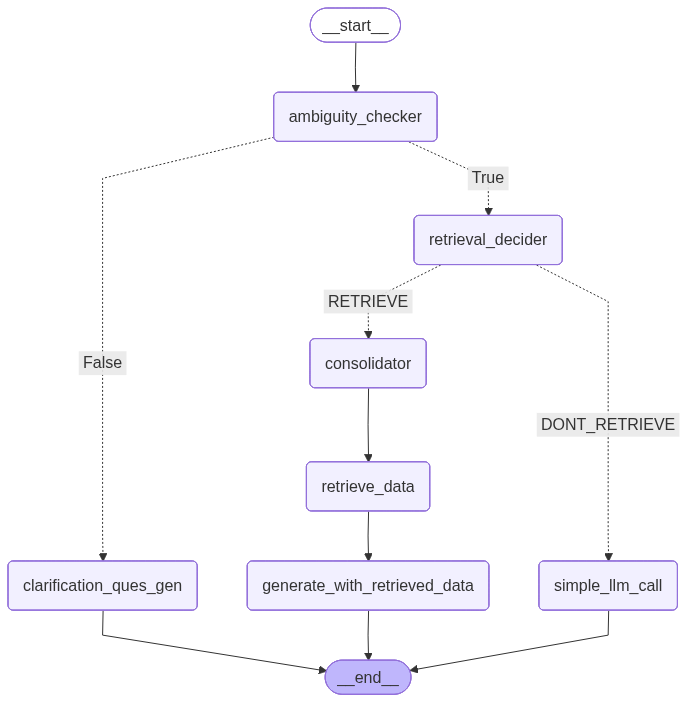

In [4]:


from IPython.display import Image, display

display(Image(workflow.get_graph().draw_mermaid_png()))

In [ ]:


stop_words = ['bye', 'stop', 'exit']

thread_id = '1'

while True:

    user_input = input("").strip()
    print("You : ", user_input)

    if user_input in stop_words:
        break

    my_chat_state = {
        'conversation_history': HumanMessage(content=user_input),
        'clarifications_asked_count': 0,
        'original_user_query': user_input

        }
    
    config = {
    'configurable': {
        'thread_id': thread_id
        }
    }   

    resp = workflow.invoke(my_chat_state, config=config)

    print('AI:' , resp['conversation_history'][-1].content)

TypeError: _ambiguity_checker_chain() takes 1 positional argument but 2 were given